TODO:
* Deal with very large matrix $K_{zx}$. When done with that, replace links in the beginning with links to the big dataset
* How to make ```imshow()``` of the large dataset?
* Implement maximum-likelihood determination of $\mu, \sigma^2$
* <strike>Deal with nonsquare data grids</strike>

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import pandas as pd 
from math import sqrt
from sklearn.metrics.pairwise import rbf_kernel
%matplotlib inline

In [2]:
#Z_coord now keeps all the data (big list)
Z_coord = pd.read_csv('USGS_NED_one_meter.xyz',
                          header=None, engine='c', sep=' ', usecols='Z',
                          names=list('XYZ'), dtype={'Z':np.float32})
qty_dots = len(Z_coord)

In [3]:
# "list" used to get the position of the first point
init_xy = pd.read_csv('USGS_NED_one_meter.xyz',
                          nrows=1, header=None, engine='c', sep=' ', usecols='XY',
                          names=list('XYZ'), dtype={'X':np.float32, 'Y':np.float32, 'Z':np.float32})

In [4]:
# Here I load several lines of XY points
# so that I get the max value of x and 
# how many points span the x line
xy_data = pd.read_csv('USGS_NED_one_meter.xyz',
                          nrows=5*int(sqrt(qty_dots)) ,header=None, engine='c', sep=' ', usecols='XY',
                          names=list('XYZ'), dtype={'X':np.float32, 'Y':np.float32, 'Z':np.float32})

rowend = xy_data['X'].argmax()
dx = xy_data['X'][1] - xy_data['X'][0]
dy = xy_data['Y'][rowend + 1] - xy_data['Y'][0]
nx = rowend + 1
ny = int(qty_dots / nx)
print('dx=%2.2f, dy=%2.2f, nx=%d, ny=%d' % (dx, dy, nx, ny))
#xy_data = []

dx=1.00, dy=1.00, nx=300, ny=385


In [5]:
## Build a coarse grid

rarity = 25  # every rarity'th point makes it to the coarse dataset

gx  = dx*np.arange(nx, dtype=np.int32)
gy  = dy*np.arange(ny, dtype=np.int32)
xx, yy = np.meshgrid(gx[::rarity], gy[::rarity])
nx_coarse = np.shape(xx)[0]
ny_coarse = np.shape(xx)[1]
qty_coarse = np.shape(xx)[0] * np.shape(xx)[1]
#qty_coarse = len(xx)
print('Points in coarse grid: %d' % qty_coarse)


Points in coarse grid: 192


In [6]:
## This block may be redundant
xx_r = xx.ravel().astype(np.int64)
yy_r = yy.ravel().astype(np.int64)
#xx_len = int(len(xx_r))
#yy_len = int(len(yy_r))
#
#xx_sqrt = int(sqrt(len(xx_r)))
#yy_sqrt = int(sqrt(len(yy_r)))
#print(xx_r)
#print(yy_r)

In [7]:
coarse_grid = np.vstack([xx_r,yy_r]).T

In [8]:
#t  = np.arange(sqrt(len(Z_coord)),dtype=np.int32)
#xx_1,yy_1 = np.meshgrid(t, t)
#
#xx_1r = xx_1.ravel()
#yy_1r = yy_1.ravel()
#
#fine_grid = np.vstack([xx_1r,yy_1r]).T
#fine_grid

In [9]:
#l = int(sqrt(len(Z_coord)))
indices = np.ravel_multi_index([yy_r,xx_r], dims=(ny, nx))

In [10]:
z = Z_coord.iloc[indices]

In [11]:
coarse_data = z.values.reshape(nx_coarse, ny_coarse)

In [12]:
sigma = 1*dx*rarity

def krige_matvec(vec, nx, ny, dx=1, dy=1, sigma=3.): 
    #print('nx %d ny %d dx %f dy %f' % (nx, ny, dx, dy))
    
    tx = np.exp(-1/(sigma**2) * (dx**2) * (np.arange(nx))**2)  
    ty = np.exp(-1/(sigma**2) * (dy**2) * (np.arange(ny))**2) 
    upper_block = np.kron(np.expand_dims(tx, axis=1), np.expand_dims(ty, axis=0))
    horz_circ = np.concatenate((upper_block, np.flip(upper_block, axis=0)[:-1]), axis=0)
    tot_circ = np.concatenate((horz_circ, np.flip(horz_circ, axis=1)[:,:-1]), axis=1)
    #print(np.shape(tot_circ))
    
    vec_mat = np.reshape(vec, ((nx,ny)))
    vec_padded = np.pad(vec_mat, ((0,nx-1),(0,ny-1)),'constant')
    #print(np.shape(vec_padded))
    
    out = np.fft.ifft2(np.fft.fft2(tot_circ) * np.fft.fft2(vec_padded))[:nx, :ny]
    return np.reshape(out, (nx*ny,1)).squeeze()

In [13]:
Kxx_LO = scipy.sparse.linalg.LinearOperator((qty_coarse, qty_coarse), 
                                            matvec=lambda v, sigma=sigma, nx=nx_coarse, ny=ny_coarse, 
                                            dx=dx*rarity, dy=dy*rarity: 
                                            krige_matvec(v, nx=nx, ny=ny, dx=dx, dy=dy, sigma=sigma))

In [14]:
epsilon = 1e-3
regularize = epsilon * sp.sparse.identity(qty_coarse)
krige = sp.sparse.linalg.gmres(Kxx_LO + sp.sparse.linalg.aslinearoperator(regularize), z, maxiter=15)

In [15]:
Kxx_c = Kxx_LO.dot(krige[0]).real

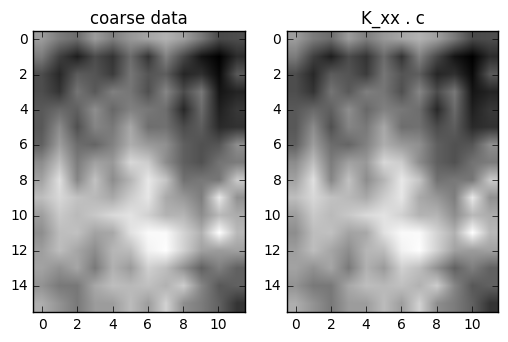

In [16]:
plt.subplot(121)
plt.imshow(coarse_data, cmap=plt.cm.gray)
plt.title('coarse data')

plt.subplot(122)
plt.imshow(np.reshape(Kxx_c, (nx_coarse,ny_coarse)), cmap=plt.cm.gray)
plt.title('K_xx . c')
plt.show()

In [17]:
## THIS NEEDS TO BE REPLACED

fine_grid = pd.read_csv('USGS_NED_one_meter.xyz',
                        header=None, engine='c', sep=' ', usecols='XY',
                        names=list('XYZ'), dtype={'X':np.float32, 'Y':np.float32, 'Z':np.float32})

#this is a painfully big matrix
K_zx = rbf_kernel(fine_grid, coarse_grid, gamma=1/sigma**2)

fine_data = K_zx.dot(krige[0]).real

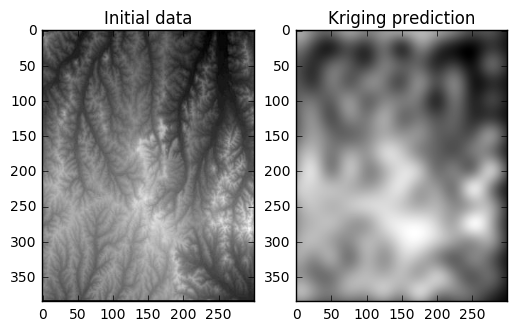

In [18]:
#nx = int(sqrt(np.shape(fine_data)[0]))

plt.subplot(121)
plt.imshow(np.reshape(Z_coord['Z'], (ny,nx)), cmap=plt.cm.gray)
plt.title('Initial data')

plt.subplot(122)
plt.imshow(np.reshape(fine_data, (ny, nx)), cmap=plt.cm.gray)
plt.title('Kriging prediction')

plt.show()